In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm
import pydicom as dicom

In [3]:
import pandas as pd
df = pd.read_parquet('data/train_dicom_tags.parquet')

In [16]:
df.columns

Index(['BitsAllocated', 'BitsStored', 'Columns', 'ContentDate', 'ContentTime',
       'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient',
       'ImagePositionPatient', 'InstanceNumber', 'KVP', 'PatientID',
       'PatientPosition', 'PhotometricInterpretation', 'PixelRepresentation',
       'PixelSpacing', 'RescaleIntercept', 'RescaleSlope', 'Rows',
       'SOPInstanceUID', 'SamplesPerPixel', 'SeriesInstanceUID',
       'SeriesNumber', 'SliceThickness', 'StudyInstanceUID', 'WindowCenter',
       'WindowWidth', 'FileMetaInformationVersion', 'ImplementationClassUID',
       'ImplementationVersionName', 'MediaStorageSOPClassUID',
       'MediaStorageSOPInstanceUID', 'TransferSyntaxUID', 'path',
       'RescaleType'],
      dtype='object')

In [18]:
df.loc[0]

BitsAllocated                                                                16
BitsStored                                                                   16
Columns                                                                     512
ContentDate                                                            20230722
ContentTime                                                       003306.881589
FrameOfReferenceUID           1.2.826.0.1.3680043.8.498.28466454913303094199...
HighBit                                                                      15
ImageOrientationPatient       [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...
ImagePositionPatient                            [-235.8665, -235.8665, 1459.20]
InstanceNumber                                                              532
KVP                                                                       120.0
PatientID                                                                 49954
PatientPosition                         

In [45]:
df.loc[0, 'SeriesInstanceUID']

'1.2.123.12345.1.2.3.49954.41479'

In [56]:
row = df[df['StudyInstanceUID'] == '10000']
u = row['PatientID'].unique().tolist()[0]
print(u)

54722


In [47]:
df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])
df.loc[0]

BitsAllocated                                                                16
BitsStored                                                                   16
Columns                                                                     512
ContentDate                                                            20230722
ContentTime                                                       003306.881589
FrameOfReferenceUID           1.2.826.0.1.3680043.8.498.28466454913303094199...
HighBit                                                                      15
ImageOrientationPatient       [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...
ImagePositionPatient                            [-235.8665, -235.8665, 1459.20]
InstanceNumber                                                              532
KVP                                                                       120.0
PatientID                                                                 49954
PatientPosition                         

In [30]:
import matplotlib.pyplot as plt
from glob import glob


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


def find_patient_from_study(study_id):
    df = pd.read_parquet("data/train_dicom_tags.parquet")
    df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])
    row = df[df['StudyInstanceUID'] == str(study_id)]
    patient_id = row['PatientID'].unique().tolist()
    return int(patient_id[0])


def find_study_from_patient(study_id):
    df = pd.read_parquet("data/train_dicom_tags.parquet")
    df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])
    row = df[df['PatientID'] == str(patient_id)]
    study_id = row['StudyInstanceUID'].unique().tolist()
    return int(study_id[0])


study_id = 18207
patient_id = find_patient_from_study(study_id)

# patient_id = 10163
# study_id = find_study_from_patient(patient_id)
print('patient_id', patient_id)
print('study_id', study_id)


patient_id 50873
study_id 18207


788
(512, 512, 3)


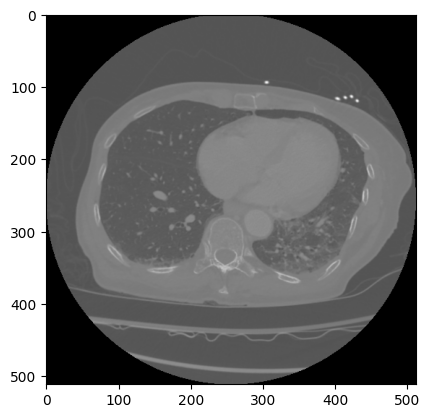

In [31]:
idx = 150
path = f'data/train_images/{patient_id}/{study_id}'
all_path =  glob(path + '/*')
all_path = sorted(all_path, key=lambda x:int(x.split("/")[-1].replace(".dcm", "")))
print(len(all_path))
img, _ = load_dicom(all_path[idx])
print(img.shape)
plt.imshow(img)
plt.show()

data/segmentations/18207.nii
(512, 512, 788)


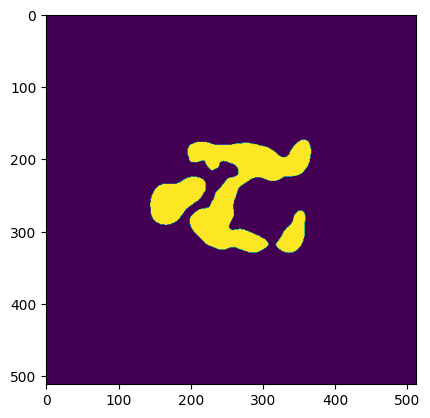

In [32]:
seg_path = f'data/segmentations/{study_id}.nii'
print(seg_path)
if os.path.exists(seg_path):
    mask = nib.load(seg_path)
    mask = mask.get_fdata()
    print(mask.shape)
    plt.imshow(mask[:, :, idx])
    plt.show()
else:
    print('dont have label')

In [46]:
import torch
seg_folder = 'data/segmentations'
all = []
for nii_file in tqdm(os.listdir(seg_folder)):
    nii_path = os.path.join(seg_folder, nii_file)
    mask = nib.load(nii_path)
    mask = mask.get_fdata()
    n_slice = mask.shape[2]
    print('n_slice', n_slice)
    zdx_list = []
    for zdx in tqdm(range(n_slice)):
        tensor = mask[:, :, zdx]
        zeros_tensor = np.zeros_like(tensor)
        is_equal = np.equal(tensor, zeros_tensor)
        if is_equal.all():
            zdx_list.append(zdx)
    all.append([nii_file, zdx_list])
zdx_df = pd.DataFrame(all, columns=['nii_file', 'non-seg-idx'])
zdx_df.head()
    

  0%|                                                                                                                                                    | 0/206 [00:00<?, ?it/s]

n_slice 291



  0%|▋                                                                                                                                         | 1/206 [00:37<2:07:54, 37.44s/it]

n_slice 139



  1%|█▎                                                                                                                                        | 2/206 [00:54<1:25:38, 25.19s/it]

n_slice 193



  1%|██                                                                                                                                        | 3/206 [01:16<1:21:23, 24.05s/it]

n_slice 168



  2%|██▋                                                                                                                                       | 4/206 [01:35<1:14:17, 22.07s/it]

n_slice 156



  2%|███▎                                                                                                                                      | 5/206 [01:54<1:09:27, 20.73s/it]

n_slice 284



  3%|████                                                                                                                                      | 6/206 [02:29<1:25:58, 25.79s/it]

n_slice 324



  3%|████▋                                                                                                                                     | 7/206 [02:50<1:19:32, 23.98s/it]

n_slice 762



  4%|█████▎                                                                                                                                    | 8/206 [04:25<2:34:39, 46.87s/it]

n_slice 747



  4%|██████                                                                                                                                    | 9/206 [05:58<3:20:43, 61.13s/it]

n_slice 78



  5%|██████▋                                                                                                                                  | 10/206 [06:07<2:27:02, 45.01s/it]

n_slice 170



  5%|███████▎                                                                                                                                 | 11/206 [06:29<2:03:45, 38.08s/it]

n_slice 208



  6%|███████▉                                                                                                                                 | 12/206 [06:53<1:48:43, 33.63s/it]

n_slice 593



  6%|████████▋                                                                                                                                | 13/206 [08:04<2:25:03, 45.09s/it]

n_slice 192



  7%|█████████▎                                                                                                                               | 14/206 [08:26<2:02:12, 38.19s/it]

n_slice 461



  7%|█████████▉                                                                                                                               | 15/206 [09:20<2:16:30, 42.88s/it]

n_slice 610



  8%|██████████▋                                                                                                                              | 16/206 [10:35<2:46:07, 52.46s/it]

n_slice 187



  8%|███████████▎                                                                                                                             | 17/206 [10:58<2:17:57, 43.79s/it]

n_slice 477



  9%|███████████▉                                                                                                                             | 18/206 [11:57<2:30:45, 48.11s/it]

n_slice 121



  9%|████████████▋                                                                                                                            | 19/206 [12:11<1:57:57, 37.85s/it]

n_slice 236



 10%|█████████████▎                                                                                                                           | 20/206 [12:54<2:02:33, 39.54s/it]

n_slice 209



 10%|█████████████▉                                                                                                                           | 21/206 [13:06<1:36:30, 31.30s/it]

n_slice 145



 11%|██████████████▋                                                                                                                          | 22/206 [13:23<1:22:22, 26.86s/it]

n_slice 169



 11%|███████████████▎                                                                                                                         | 23/206 [13:43<1:16:15, 25.00s/it]

n_slice 335



 12%|███████████████▉                                                                                                                         | 24/206 [14:23<1:29:25, 29.48s/it]

n_slice 69



 12%|████████████████▋                                                                                                                        | 25/206 [14:31<1:09:38, 23.09s/it]

n_slice 427



 13%|█████████████████▎                                                                                                                       | 26/206 [15:23<1:34:35, 31.53s/it]

n_slice 105



 13%|█████████████████▉                                                                                                                       | 27/206 [15:35<1:16:34, 25.67s/it]

n_slice 751



 14%|██████████████████▌                                                                                                                      | 28/206 [16:20<1:33:19, 31.46s/it]

n_slice 677



 14%|███████████████████▎                                                                                                                     | 29/206 [17:45<2:20:44, 47.71s/it]

n_slice 69



 15%|███████████████████▉                                                                                                                     | 30/206 [17:53<1:45:09, 35.85s/it]

n_slice 586



 15%|████████████████████▌                                                                                                                    | 31/206 [19:04<2:15:04, 46.31s/it]

n_slice 189



 16%|█████████████████████▎                                                                                                                   | 32/206 [19:27<1:53:42, 39.21s/it]

n_slice 365



 16%|█████████████████████▉                                                                                                                   | 33/206 [20:10<1:56:34, 40.43s/it]

n_slice 293



 17%|██████████████████████▌                                                                                                                  | 34/206 [20:45<1:50:57, 38.71s/it]

n_slice 122



 17%|███████████████████████▎                                                                                                                 | 35/206 [21:01<1:30:52, 31.89s/it]

n_slice 715



 17%|███████████████████████▉                                                                                                                 | 36/206 [22:24<2:14:19, 47.41s/it]

n_slice 303



 18%|████████████████████████▌                                                                                                                | 37/206 [23:02<2:05:43, 44.64s/it]

n_slice 170



 18%|█████████████████████████▎                                                                                                               | 38/206 [23:24<1:45:14, 37.59s/it]

n_slice 441



 19%|█████████████████████████▉                                                                                                               | 39/206 [24:18<1:58:27, 42.56s/it]

n_slice 113



 19%|██████████████████████████▌                                                                                                              | 40/206 [24:37<1:38:15, 35.51s/it]

n_slice 257



 20%|███████████████████████████▎                                                                                                             | 41/206 [25:07<1:33:09, 33.87s/it]

n_slice 250



 20%|███████████████████████████▉                                                                                                             | 42/206 [25:37<1:29:08, 32.61s/it]

n_slice 158



 21%|████████████████████████████▌                                                                                                            | 43/206 [25:55<1:16:58, 28.34s/it]

n_slice 236



 21%|█████████████████████████████▎                                                                                                           | 44/206 [26:36<1:26:55, 32.19s/it]

n_slice 269



 22%|█████████████████████████████▉                                                                                                           | 45/206 [27:08<1:26:18, 32.16s/it]

n_slice 385



 22%|██████████████████████████████▌                                                                                                          | 46/206 [27:55<1:37:06, 36.41s/it]

n_slice 216



 23%|███████████████████████████████▎                                                                                                         | 47/206 [28:33<1:38:01, 36.99s/it]

n_slice 391



 23%|███████████████████████████████▉                                                                                                         | 48/206 [29:20<1:45:04, 39.90s/it]

n_slice 176



 24%|████████████████████████████████▌                                                                                                        | 49/206 [29:41<1:29:58, 34.39s/it]

n_slice 47



 24%|█████████████████████████████████▎                                                                                                       | 50/206 [29:47<1:06:53, 25.73s/it]

n_slice 804



 25%|█████████████████████████████████▉                                                                                                       | 51/206 [31:20<1:59:18, 46.18s/it]

n_slice 435



 25%|██████████████████████████████████▌                                                                                                      | 52/206 [32:13<2:03:19, 48.05s/it]

n_slice 195



 26%|███████████████████████████████████▏                                                                                                     | 53/206 [32:36<1:43:09, 40.46s/it]

n_slice 154



 26%|███████████████████████████████████▉                                                                                                     | 54/206 [32:55<1:26:13, 34.03s/it]

n_slice 189



 27%|████████████████████████████████████▌                                                                                                    | 55/206 [33:18<1:17:45, 30.90s/it]

n_slice 191



 27%|█████████████████████████████████████▏                                                                                                   | 56/206 [33:42<1:11:38, 28.65s/it]

n_slice 501



 28%|█████████████████████████████████████▉                                                                                                   | 57/206 [34:42<1:34:54, 38.22s/it]

n_slice 269



 28%|██████████████████████████████████████▌                                                                                                  | 58/206 [35:15<1:29:54, 36.45s/it]

n_slice 221



 29%|███████████████████████████████████████▏                                                                                                 | 59/206 [35:40<1:21:04, 33.09s/it]

n_slice 171



 29%|███████████████████████████████████████▉                                                                                                 | 60/206 [35:59<1:10:31, 28.98s/it]

n_slice 106



 30%|█████████████████████████████████████████▏                                                                                                 | 61/206 [36:06<53:40, 22.21s/it]

n_slice 323



 30%|█████████████████████████████████████████▏                                                                                               | 62/206 [36:44<1:05:03, 27.11s/it]

n_slice 635



 31%|█████████████████████████████████████████▉                                                                                               | 63/206 [38:03<1:41:51, 42.74s/it]

n_slice 179



 31%|██████████████████████████████████████████▌                                                                                              | 64/206 [38:27<1:27:28, 36.96s/it]

n_slice 688



 32%|███████████████████████████████████████████▏                                                                                             | 65/206 [39:44<1:55:07, 48.99s/it]

n_slice 226



 32%|███████████████████████████████████████████▉                                                                                             | 66/206 [40:31<1:53:18, 48.56s/it]

n_slice 763



 33%|████████████████████████████████████████████▌                                                                                            | 67/206 [42:08<2:25:48, 62.94s/it]

n_slice 246



 33%|█████████████████████████████████████████████▏                                                                                           | 68/206 [42:40<2:03:11, 53.56s/it]

n_slice 284



 33%|█████████████████████████████████████████████▉                                                                                           | 69/206 [43:18<1:51:43, 48.93s/it]

n_slice 81



 34%|██████████████████████████████████████████████▌                                                                                          | 70/206 [43:28<1:24:27, 37.26s/it]

n_slice 185



 34%|███████████████████████████████████████████████▏                                                                                         | 71/206 [43:51<1:14:40, 33.19s/it]

n_slice 644



 35%|███████████████████████████████████████████████▉                                                                                         | 72/206 [45:13<1:46:49, 47.83s/it]

n_slice 533



 35%|████████████████████████████████████████████████▌                                                                                        | 73/206 [46:24<2:01:16, 54.71s/it]

n_slice 167



 36%|█████████████████████████████████████████████████▏                                                                                       | 74/206 [46:45<1:37:38, 44.38s/it]

n_slice 112



 36%|█████████████████████████████████████████████████▉                                                                                       | 75/206 [46:58<1:16:59, 35.26s/it]

n_slice 317



 37%|██████████████████████████████████████████████████▌                                                                                      | 76/206 [47:40<1:20:13, 37.02s/it]

n_slice 312



 37%|███████████████████████████████████████████████████▏                                                                                     | 77/206 [48:21<1:22:30, 38.38s/it]

n_slice 371



 38%|███████████████████████████████████████████████████▊                                                                                     | 78/206 [49:07<1:26:33, 40.58s/it]

n_slice 415



 38%|████████████████████████████████████████████████████▌                                                                                    | 79/206 [49:58<1:32:49, 43.86s/it]

n_slice 64



 39%|█████████████████████████████████████████████████████▏                                                                                   | 80/206 [50:06<1:09:32, 33.11s/it]

n_slice 195



 39%|█████████████████████████████████████████████████████▊                                                                                   | 81/206 [50:29<1:02:27, 29.98s/it]

n_slice 466



 40%|██████████████████████████████████████████████████████▌                                                                                  | 82/206 [51:28<1:19:57, 38.69s/it]

n_slice 181



 40%|███████████████████████████████████████████████████████▏                                                                                 | 83/206 [51:51<1:09:37, 33.96s/it]

n_slice 682



 41%|███████████████████████████████████████████████████████▊                                                                                 | 84/206 [53:18<1:41:08, 49.74s/it]

n_slice 538



 41%|████████████████████████████████████████████████████████▌                                                                                | 85/206 [54:25<1:51:02, 55.06s/it]

n_slice 828



 42%|█████████████████████████████████████████████████████████▏                                                                               | 86/206 [56:11<2:20:41, 70.35s/it]

n_slice 296



 42%|█████████████████████████████████████████████████████████▊                                                                               | 87/206 [56:49<2:00:12, 60.61s/it]

n_slice 192



 43%|██████████████████████████████████████████████████████████▌                                                                              | 88/206 [57:12<1:37:06, 49.37s/it]

n_slice 312



 43%|███████████████████████████████████████████████████████████▏                                                                             | 89/206 [57:54<1:31:41, 47.02s/it]

n_slice 532



 44%|███████████████████████████████████████████████████████████▊                                                                             | 90/206 [59:01<1:42:34, 53.06s/it]

n_slice 483



 44%|███████████████████████████████████████████████████████████▋                                                                           | 91/206 [1:00:02<1:46:09, 55.39s/it]

n_slice 365



 45%|████████████████████████████████████████████████████████████▎                                                                          | 92/206 [1:00:49<1:40:40, 52.99s/it]

n_slice 291



 45%|████████████████████████████████████████████████████████████▉                                                                          | 93/206 [1:01:26<1:30:37, 48.12s/it]

n_slice 843



 46%|█████████████████████████████████████████████████████████████▌                                                                         | 94/206 [1:02:19<1:32:30, 49.56s/it]

n_slice 473



 46%|██████████████████████████████████████████████████████████████▎                                                                        | 95/206 [1:03:16<1:36:05, 51.94s/it]

n_slice 797



 47%|██████████████████████████████████████████████████████████████▉                                                                        | 96/206 [1:04:44<1:54:57, 62.70s/it]

n_slice 68



 47%|███████████████████████████████████████████████████████████████▌                                                                       | 97/206 [1:04:53<1:24:35, 46.56s/it]

n_slice 221



 48%|████████████████████████████████████████████████████████████████▏                                                                      | 98/206 [1:05:19<1:12:44, 40.41s/it]

n_slice 107



 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 99/206 [1:05:32<57:09, 32.05s/it]

n_slice 306



 49%|██████████████████████████████████████████████████████████████████                                                                      | 100/206 [1:06:09<59:41, 33.79s/it]

n_slice 101



 49%|██████████████████████████████████████████████████████████████████▋                                                                     | 101/206 [1:06:21<47:28, 27.12s/it]

n_slice 168



 50%|███████████████████████████████████████████████████████████████████▎                                                                    | 102/206 [1:06:41<43:22, 25.02s/it]

n_slice 718



 50%|███████████████████████████████████████████████████████████████████                                                                   | 103/206 [1:08:09<1:15:22, 43.91s/it]

n_slice 352



 50%|███████████████████████████████████████████████████████████████████▋                                                                  | 104/206 [1:08:51<1:13:36, 43.30s/it]

n_slice 229



 51%|████████████████████████████████████████████████████████████████████▎                                                                 | 105/206 [1:09:18<1:04:56, 38.57s/it]

n_slice 619



 51%|████████████████████████████████████████████████████████████████████▉                                                                 | 106/206 [1:10:32<1:21:44, 49.05s/it]

n_slice 246



 52%|█████████████████████████████████████████████████████████████████████▌                                                                | 107/206 [1:11:03<1:11:54, 43.58s/it]

n_slice 208



 52%|██████████████████████████████████████████████████████████████████████▎                                                               | 108/206 [1:11:29<1:02:41, 38.38s/it]

n_slice 226



 53%|███████████████████████████████████████████████████████████████████████▉                                                                | 109/206 [1:11:56<56:29, 34.95s/it]

n_slice 180



 53%|████████████████████████████████████████████████████████████████████████▌                                                               | 110/206 [1:12:19<50:06, 31.32s/it]

n_slice 403



 54%|█████████████████████████████████████████████████████████████████████████▎                                                              | 111/206 [1:13:06<57:04, 36.05s/it]

n_slice 314



 54%|█████████████████████████████████████████████████████████████████████████▉                                                              | 112/206 [1:13:44<57:23, 36.63s/it]

n_slice 88



 55%|██████████████████████████████████████████████████████████████████████████▌                                                             | 113/206 [1:13:54<44:33, 28.75s/it]

n_slice 113



 55%|███████████████████████████████████████████████████████████████████████████▎                                                            | 114/206 [1:14:08<36:58, 24.12s/it]

n_slice 266



 56%|███████████████████████████████████████████████████████████████████████████▉                                                            | 115/206 [1:14:40<40:11, 26.50s/it]

n_slice 203



 56%|████████████████████████████████████████████████████████████████████████████▌                                                           | 116/206 [1:15:04<38:39, 25.77s/it]

n_slice 601



 57%|█████████████████████████████████████████████████████████████████████████████▏                                                          | 117/206 [1:16:15<58:36, 39.51s/it]

n_slice 178



 57%|█████████████████████████████████████████████████████████████████████████████▉                                                          | 118/206 [1:16:38<50:32, 34.46s/it]

n_slice 773



 58%|█████████████████████████████████████████████████████████████████████████████▍                                                        | 119/206 [1:18:13<1:16:15, 52.60s/it]

n_slice 768



 58%|██████████████████████████████████████████████████████████████████████████████                                                        | 120/206 [1:19:45<1:32:23, 64.46s/it]

n_slice 180



 59%|██████████████████████████████████████████████████████████████████████████████▋                                                       | 121/206 [1:19:56<1:08:46, 48.54s/it]

n_slice 221



 59%|████████████████████████████████████████████████████████████████████████████████▌                                                       | 122/206 [1:20:23<58:46, 41.99s/it]

n_slice 604



 60%|████████████████████████████████████████████████████████████████████████████████                                                      | 123/206 [1:21:36<1:10:44, 51.14s/it]

n_slice 518



 60%|████████████████████████████████████████████████████████████████████████████████▋                                                     | 124/206 [1:22:41<1:15:51, 55.50s/it]

n_slice 198



 61%|█████████████████████████████████████████████████████████████████████████████████▎                                                    | 125/206 [1:23:05<1:02:10, 46.06s/it]

n_slice 212



 61%|███████████████████████████████████████████████████████████████████████████████████▏                                                    | 126/206 [1:23:30<52:54, 39.68s/it]

n_slice 720



 62%|███████████████████████████████████████████████████████████████████████████████████▊                                                    | 127/206 [1:24:13<53:27, 40.60s/it]

n_slice 326



 62%|████████████████████████████████████████████████████████████████████████████████████▌                                                   | 128/206 [1:24:51<51:53, 39.91s/it]

n_slice 584



 63%|███████████████████████████████████████████████████████████████████████████████████▉                                                  | 129/206 [1:25:59<1:02:00, 48.32s/it]

n_slice 203



 63%|█████████████████████████████████████████████████████████████████████████████████████▊                                                  | 130/206 [1:26:24<52:30, 41.45s/it]

n_slice 259



 64%|██████████████████████████████████████████████████████████████████████████████████████▍                                                 | 131/206 [1:27:18<56:26, 45.15s/it]

n_slice 575



 64%|█████████████████████████████████████████████████████████████████████████████████████▊                                                | 132/206 [1:28:30<1:05:22, 53.00s/it]

n_slice 526



 65%|██████████████████████████████████████████████████████████████████████████████████████▌                                               | 133/206 [1:29:34<1:08:46, 56.52s/it]

n_slice 268



 65%|████████████████████████████████████████████████████████████████████████████████████████▍                                               | 134/206 [1:30:06<58:59, 49.16s/it]

n_slice 99



 66%|█████████████████████████████████████████████████████████████████████████████████████████▏                                              | 135/206 [1:30:18<44:53, 37.93s/it]

n_slice 169



 66%|█████████████████████████████████████████████████████████████████████████████████████████▊                                              | 136/206 [1:30:37<37:43, 32.34s/it]

n_slice 187



 67%|██████████████████████████████████████████████████████████████████████████████████████████▍                                             | 137/206 [1:30:49<30:07, 26.19s/it]

n_slice 481



 67%|███████████████████████████████████████████████████████████████████████████████████████████                                             | 138/206 [1:31:47<40:31, 35.75s/it]

n_slice 505



 67%|███████████████████████████████████████████████████████████████████████████████████████████▊                                            | 139/206 [1:32:48<48:10, 43.14s/it]

n_slice 205



 68%|████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 140/206 [1:33:12<41:08, 37.40s/it]

n_slice 204



 68%|█████████████████████████████████████████████████████████████████████████████████████████████                                           | 141/206 [1:33:36<36:09, 33.38s/it]

n_slice 114



 69%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 142/206 [1:33:49<29:04, 27.25s/it]

n_slice 1022



 69%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 143/206 [1:35:53<59:12, 56.40s/it]

n_slice 175



 70%|███████████████████████████████████████████████████████████████████████████████████████████████                                         | 144/206 [1:36:14<47:18, 45.79s/it]

n_slice 725



 70%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 145/206 [1:37:39<58:37, 57.67s/it]

n_slice 768



 71%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 146/206 [1:39:13<1:08:20, 68.35s/it]

n_slice 185



 71%|█████████████████████████████████████████████████████████████████████████████████████████████████                                       | 147/206 [1:39:36<53:53, 54.81s/it]

n_slice 375



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 148/206 [1:40:19<49:39, 51.37s/it]

n_slice 152



 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 149/206 [1:40:36<39:03, 41.12s/it]

n_slice 154



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████                                     | 150/206 [1:40:54<31:55, 34.20s/it]

n_slice 168



 73%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 151/206 [1:41:07<25:21, 27.66s/it]

n_slice 106



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 152/206 [1:41:20<20:52, 23.20s/it]

n_slice 684



 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 153/206 [1:42:44<36:35, 41.43s/it]

n_slice 239



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 154/206 [1:43:12<32:25, 37.42s/it]

n_slice 310



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 155/206 [1:43:49<31:53, 37.53s/it]

n_slice 174



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 156/206 [1:44:10<27:07, 32.55s/it]

n_slice 256



 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 157/206 [1:44:41<26:01, 31.87s/it]

n_slice 827



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/206 [1:46:19<41:28, 51.84s/it]

n_slice 80



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 159/206 [1:46:28<30:34, 39.02s/it]

n_slice 371



 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 160/206 [1:47:13<31:11, 40.68s/it]

n_slice 294



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 161/206 [1:47:49<29:26, 39.25s/it]

n_slice 327



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 162/206 [1:48:28<28:47, 39.25s/it]

n_slice 88



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 163/206 [1:48:39<22:00, 30.70s/it]

n_slice 730



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 164/206 [1:50:06<33:18, 47.59s/it]

n_slice 62



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 165/206 [1:50:13<24:15, 35.51s/it]

n_slice 296



 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 166/206 [1:50:49<23:49, 35.74s/it]

n_slice 696



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 167/206 [1:51:33<24:44, 38.06s/it]

n_slice 861



 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 168/206 [1:53:14<36:10, 57.13s/it]

n_slice 252



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 169/206 [1:53:46<30:29, 49.45s/it]

n_slice 59



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 170/206 [1:53:53<21:57, 36.61s/it]

n_slice 205



 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 171/206 [1:54:16<19:03, 32.66s/it]

n_slice 364



 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 172/206 [1:54:59<20:15, 35.74s/it]

n_slice 222



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 173/206 [1:55:25<17:59, 32.70s/it]

n_slice 245



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 174/206 [1:55:53<16:43, 31.37s/it]

n_slice 583



 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 175/206 [1:57:07<22:49, 44.17s/it]

n_slice 71



 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 176/206 [1:57:16<16:47, 33.57s/it]

n_slice 184



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 177/206 [1:57:38<14:37, 30.28s/it]

n_slice 94



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 178/206 [1:57:50<11:28, 24.60s/it]

n_slice 213



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 179/206 [1:58:16<11:15, 25.00s/it]

n_slice 319



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 180/206 [1:58:55<12:42, 29.33s/it]

n_slice 491



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 181/206 [1:59:55<16:01, 38.45s/it]

n_slice 703



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 182/206 [2:01:19<20:50, 52.12s/it]

n_slice 663



 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 183/206 [2:02:39<23:10, 60.45s/it]

n_slice 1044



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 184/206 [2:04:40<28:53, 78.79s/it]

n_slice 243



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 185/206 [2:05:10<22:27, 64.15s/it]

n_slice 324



 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 186/206 [2:05:48<18:43, 56.19s/it]

n_slice 230



 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 187/206 [2:06:16<15:06, 47.72s/it]

n_slice 306



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 188/206 [2:06:54<13:25, 44.75s/it]

n_slice 186



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 189/206 [2:07:05<09:49, 34.66s/it]

n_slice 229



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 190/206 [2:07:33<08:44, 32.79s/it]

n_slice 190



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 191/206 [2:07:56<07:27, 29.87s/it]

n_slice 184



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 192/206 [2:08:18<06:23, 27.36s/it]

n_slice 53



 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 193/206 [2:08:24<04:32, 20.94s/it]

n_slice 84



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 194/206 [2:08:34<03:33, 17.77s/it]

n_slice 835



 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 195/206 [2:10:10<07:34, 41.28s/it]

n_slice 176



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 196/206 [2:10:31<05:50, 35.04s/it]

n_slice 197



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 197/206 [2:10:55<04:46, 31.87s/it]

n_slice 690



 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 198/206 [2:12:14<06:08, 46.07s/it]

n_slice 196



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 199/206 [2:12:26<04:10, 35.72s/it]

n_slice 251



 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 200/206 [2:12:59<03:29, 34.94s/it]

n_slice 293



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 201/206 [2:13:37<02:58, 35.71s/it]

n_slice 412



 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 202/206 [2:14:26<02:39, 39.94s/it]

n_slice 631



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 203/206 [2:15:42<02:31, 50.62s/it]

n_slice 850



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 204/206 [2:16:35<01:42, 51.29s/it]

n_slice 252



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 205/206 [2:17:19<00:49, 49.06s/it]

n_slice 788



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 206/206 [2:17:22<00:00, 40.01s/it]


,nii_file,non-seg-idx
0,6575.nii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,62556.nii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,60755.nii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,60302.nii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,31852.nii,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [47]:
zdx_df.to_csv('data/non-seg-idx.csv', index=False)

In [48]:
import sys
np.set_printoptions(threshold=sys.maxsize)
# mask[:, :, idx]

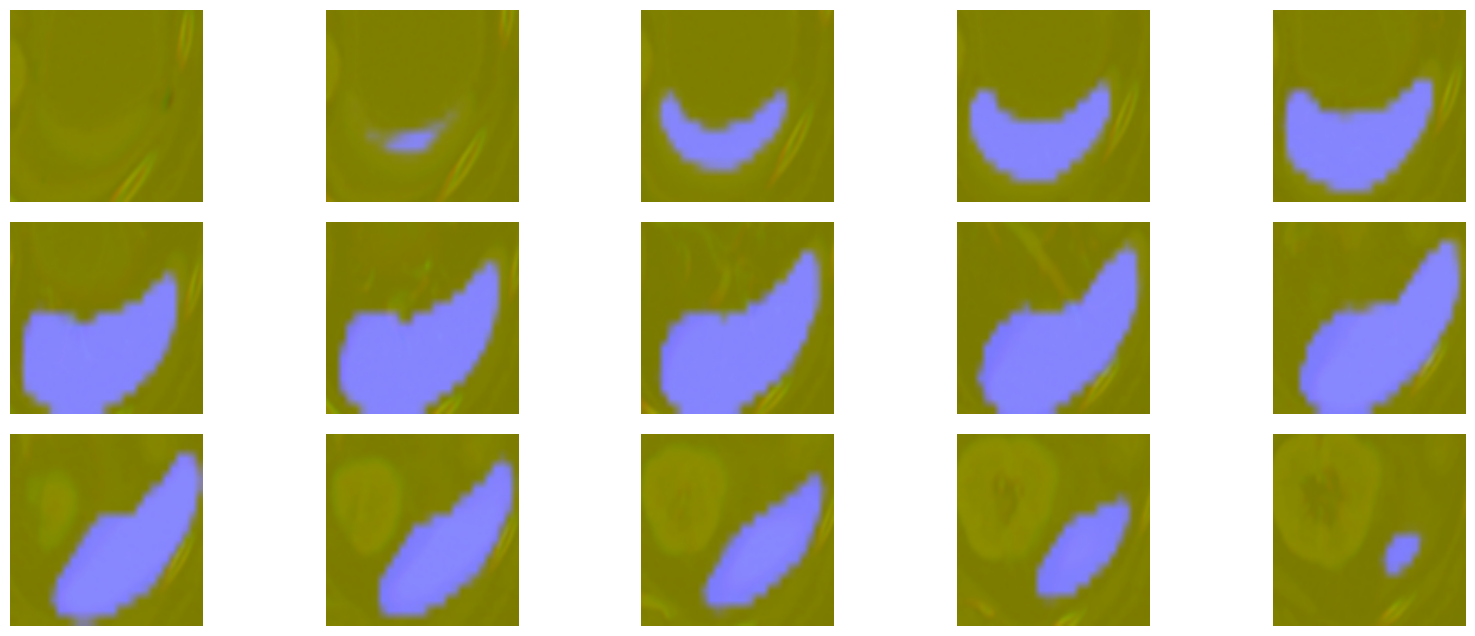

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 5, figsize=(20, 8))
axes = axes.ravel()

cid = 1
for nid in range(15):
    image = np.load(f"data/stage1/crop/{patient_id}_{study_id}_{cid}_{nid}.npy")
    image = image[:, :, 3:]
    # plt.imshow(image)
    # plt.show()
    # print(f"data/stage1/crop/{patient_id}_{study_id}_{cid}_{nid}.npy")
    axes[nid].imshow(image)
    axes[nid].axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [189]:
# remove all healthy in df
zzdf = pd.read_csv('data/stage1/train_cls.csv')
print(len(zzdf))
cnt = 0
new_df_z = []
for idx in tqdm(range(len(zzdf))):
    row = zzdf.loc[idx]
    healthy = all([1 - row.bowel, 1 - row.kidney, 1 - row.liver, 1- row.spleen])
    if not healthy:
        cnt += 1
        new_df_z.append(row)        

new_df = pd.DataFrame(new_df_z, columns=['patient_id', 'study_id', 'bowel', 'kidney', 'liver', 'spleen', 'cid', 'fold'])
print('num injury', cnt)
new_df.to_csv('data/stage2/train_cls.csv', index=False)
vv_df = pd.read_csv('data/stage2/train_cls.csv')
cnt_bowel = 0
cnt_kidney = 0
cnt_liver = 0
cnt_spleen = 0
for idx in range(len(vv_df)):
    if vv_df.loc[idx, 'bowel'] == 1:
        cnt_bowel += 1
    if vv_df.loc[idx, 'kidney'] == 1:
        cnt_kidney += 1
    if vv_df.loc[idx, 'spleen'] == 1:
        cnt_spleen += 1
    if vv_df.loc[idx, 'liver'] == 1:
        cnt_liver += 1
print(cnt_bowel)
print(cnt_kidney)
print(cnt_liver)
print(cnt_spleen)

23419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23419/23419 [00:01<00:00, 12695.99it/s]


num injury 5728


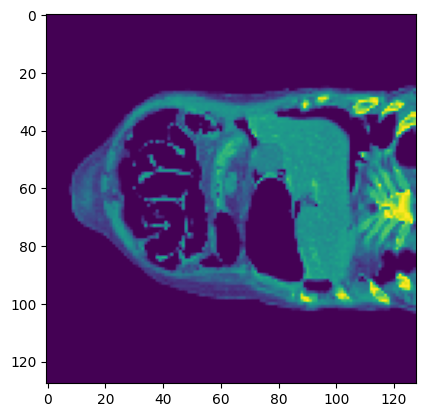

In [78]:
mask = np.load('data/stage2/image/6575.npy')
plt.imshow(mask[:, :, :])
plt.show()

In [2]:
import pandas as pd
df = pd.read_parquet("data/train_dicom_tags.parquet")
df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])
df.head()

,BitsAllocated,BitsStored,Columns,ContentDate,ContentTime,FrameOfReferenceUID,HighBit,ImageOrientationPatient,ImagePositionPatient,InstanceNumber,...,WindowCenter,WindowWidth,FileMetaInformationVersion,ImplementationClassUID,ImplementationVersionName,MediaStorageSOPClassUID,MediaStorageSOPInstanceUID,TransferSyntaxUID,path,RescaleType
0,16,16,512,20230722,003306.881589,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1459.20]",532,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.532,1.2.840.10008.1.2.5,train_images/49954/41479/532.dcm,nan
1,16,16,512,20230722,003303.279137,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1474.40]",513,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.513,1.2.840.10008.1.2.5,train_images/49954/41479/513.dcm,nan
2,16,16,512,20230722,003343.090736,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1310.40]",718,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.718,1.2.840.10008.1.2.5,train_images/49954/41479/718.dcm,nan
3,16,16,512,20230722,003252.960345,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1520.00]",456,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.456,1.2.840.10008.1.2.5,train_images/49954/41479/456.dcm,nan
4,16,16,512,20230722,003155.059398,1.2.826.0.1.3680043.8.498.28466454913303094199...,15,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[-235.8665, -235.8665, 1756.00]",161,...,50.0,400.0, ,1.2.3.123456.4.5.1234.1.12.0,PYDICOM 2.4.0,1.2.840.10008.5.1.4.1.1.2,1.2.123.12345.1.2.3.49954.1.161,1.2.840.10008.1.2.5,train_images/49954/41479/161.dcm,nan


In [1]:
import pandas as pd
df = pd.read_csv('data/train.csv')
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [14]:
extra = df[df['extravasation_healthy'] < 1]
bowel = extra['bowel_healthy'].tolist()
kidney = extra['kidney_healthy'].tolist()
liver = extra['liver_healthy'].tolist()
spleen = extra['spleen_healthy'].tolist()

In [15]:
# bowel 2%
# extra 6.4%
for i in range(len(bowel)):
    print('-----------------')
    print('bowel', bowel[i])
    print('kidney', kidney[i])
    print('liver', liver[i])
    print('spleen', spleen[i])

-----------------
bowel 1
kidney 0
liver 1
spleen 0
-----------------
bowel 1
kidney 1
liver 0
spleen 0
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 0
-----------------
bowel 0
kidney 1
liver 1
spleen 0
-----------------
bowel 1
kidney 1
liver 1
spleen 0
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 0
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 0
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 0
spleen 0
-----------------
bowel 1
kidney 1
liver 1
spleen 1
-----------------
bowel 1
kidney 1
liver 0
spleen 1
-----------------
bowel 1
kidney 0
liver 1
spleen 1
------------

In [24]:
# check = df[((df['liver_low'] == 1) | (df['liver_high'] == 1)) & ((df['kidney_low'] == 1) | (df['kidney_high'] == 1))]
check = df[df['extravasation_healthy'] < 1]

check.head(50)

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
16,10217,1,0,0,1,1,0,0,0,1,0,0,0,1,1
22,10292,1,0,0,1,1,0,0,1,0,0,1,0,0,1
28,10494,1,0,0,1,1,0,0,1,0,0,1,0,0,1
57,11044,1,0,0,1,1,0,0,1,0,0,1,0,0,1
70,11379,1,0,0,1,1,0,0,1,0,0,1,0,0,1
76,11474,1,0,0,1,1,0,0,1,0,0,1,0,0,1
84,11652,1,0,0,1,1,0,0,1,0,0,0,0,1,1
101,11925,0,1,0,1,1,0,0,1,0,0,0,1,0,1
104,12008,1,0,0,1,1,0,0,1,0,0,0,0,1,1
